In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('../tools/')
import tools
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn.pipeline import make_pipeline

In [63]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
# x_train = train.drop(['SalePrice', 'Id'],axis=1)
# y_train = train.SalePrice
# x_test = test.drop(['Id'],axis=1)

In [64]:
## Combining train and test datasets together so that we can do all the work at once. 
all_data = pd.concat((train, test)).reset_index(drop = True)
## Dropping the target variable. 
all_data.drop(['SalePrice'], axis = 1, inplace = True)

/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [65]:
## Some missing values are intentionally left blank, for example: In the Alley feature 
## there are blank values meaning that there are no alley's in that specific house. 
missing_val_col = [
                    "Alley", 
                   "PoolQC", 
                   "MiscFeature",
                   "Fence",
                   "FireplaceQu",
                   "GarageType",
                   "GarageFinish",
                   "GarageQual",
                   "GarageCond",
                   'BsmtQual',
                   'BsmtCond',
                   'BsmtExposure',
                   'BsmtFinType1',
                   'BsmtFinType2',
                   'MasVnrType']
# for i in missing_val_col:
#     prc.x_all[i] = prc.x_all[i].fillna('None')
    
for i in missing_val_col:
    all_data[i] = all_data[i].fillna('None')
    
## These features are continous variable, we used "0" to replace the null values. 
missing_val_col2 = [
                    'BsmtFinSF1',
                    'BsmtFinSF2',
                    'BsmtUnfSF',
                    'TotalBsmtSF',
                    'BsmtFullBath', 
                    'BsmtHalfBath', 
                    'GarageYrBlt',
                    'GarageArea',
                    'GarageCars',
                    'MasVnrArea']
# for i in missing_val_col2:
#     prc.x_all[i] = prc.x_all[i].fillna(0)

for i in missing_val_col2:
    all_data[i] = all_data[i].fillna(0)
    
## Replaced all missing values in LotFrontage by imputing the median value of each neighborhood. 
# prc.x_all['LotFrontage'] = prc.x_all.groupby('Neighborhood')['LotFrontage'].transform( lambda x: x.fillna(x.mean()))

all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform( lambda x: x.fillna(x.mean()))


## Zoning class are given in numerical; therefore converted to categorical variables. 
# prc.x_all['MSSubClass'] = prc.x_all['MSSubClass'].astype(str)
# prc.x_all['MSZoning'] = prc.x_all.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)
all_data['MSZoning'] = all_data.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

## Important years and months that should be categorical variables not numerical. 
# prc.x_all['YrSold'] = prc.x_all['YrSold'].astype(str)
# prc.x_all['MoSold'] = prc.x_all['MoSold'].astype(str) 

# prc.x_all['Functional'] = prc.x_all['Functional'].fillna(prc.x_all['Functional'].mode()[0]) 
# prc.x_all['Utilities'] = prc.x_all['Utilities'].fillna(prc.x_all['Utilities'].mode()[0]) 
# prc.x_all['Exterior1st'] = prc.x_all['Exterior1st'].fillna(prc.x_all['Exterior1st'].mode()[0]) 
# prc.x_all['Exterior2nd'] = prc.x_all['Exterior2nd'].fillna(prc.x_all['Exterior2nd'].mode()[0])
# prc.x_all['KitchenQual'] = prc.x_all['KitchenQual'].fillna(prc.x_all['KitchenQual'].mode()[0]) 
# prc.x_all['SaleType'] = prc.x_all['SaleType'].fillna(prc.x_all['SaleType'].mode()[0])
# prc.x_all['Electrical'] = prc.x_all['Electrical'].fillna(prc.x_all['Electrical'].mode()[0]) 

all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str) 

all_data['Functional'] = all_data['Functional'].fillna('Typ') 
all_data['Utilities'] = all_data['Utilities'].fillna('AllPub') 
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0]) 
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna("TA") 
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['Electrical'] = all_data['Electrical'].fillna("SBrkr") 

## Dealing with Skewed Features

In [66]:
# prc.Skews(bar=False, get_return=True)
from scipy.stats import skew
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
# skewed_feats

In [10]:
# prc_init.viewF(input_cols=['1stFlrSF'])

In [67]:
# prc.transF(threshold=0.5, method='boxcox', inplace=True, get_return=False)
# prc.viewF(input_cols=['1stFlrSF'])

def fixing_skewness(df):
    """
    This function takes in a dataframe and return fixed skewed dataframe
    """
    ## Import necessary modules 
    from scipy.stats import skew
    from scipy.special import boxcox1p
    from scipy.stats import boxcox_normmax
    
    ## Getting all the data that are not of "object" type. 
    numeric_feats = df.dtypes[df.dtypes != "object"].index

    # Check the skew of all numerical features
    skewed_feats = df[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
    high_skew = skewed_feats[abs(skewed_feats) > 0.5]
    skewed_features = high_skew.index

    for feat in skewed_features:
        df[feat] = boxcox1p(df[feat], boxcox_normmax(df[feat] + 1))

fixing_skewness(all_data)


/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/stats.py:3429: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


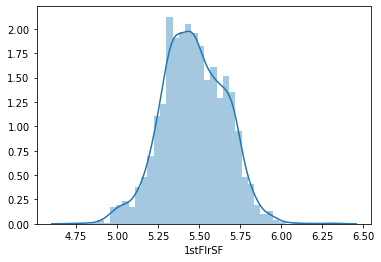

In [68]:
import seaborn as sns
sns.distplot(all_data['1stFlrSF'])

## Drop Features

In [15]:
# prc.x_all = prc.x_all.drop(['Utilities', 'Street', 'PoolQC',], axis=1)
all_data = all_data.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

## Make new Features

### Make Features about SF

In [69]:
all_data = all_data.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

# feture engineering a new feature "TotalFS"
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['YrBltAndRemod']=all_data['YearBuilt']+all_data['YearRemodAdd']

all_data['Total_sqr_footage'] = (all_data['BsmtFinSF1'] + all_data['BsmtFinSF2'] +
                                 all_data['1stFlrSF'] + all_data['2ndFlrSF'])

all_data['Total_Bathrooms'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) +
                               all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))

all_data['Total_porch_sf'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] +
                              all_data['EnclosedPorch'] + all_data['ScreenPorch'] +
                              all_data['WoodDeckSF'])

In [70]:


all_data['haspool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['has2ndfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasgarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasbsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)



### Make Dummy Variables

In [71]:
# prc.x_all.shape

all_data.shape

(2919, 87)

In [20]:
# final_features = pd.get_dummies(prc.x_all).reset_index(drop=True)
# final_features.shape

final_features = pd.get_dummies(all_data).reset_index(drop=True)
final_features.shape

(2919, 325)

### Option

In [22]:
# X = final_features.iloc[:len(prc.y_train), :]
# X_sub = final_features.iloc[len(prc.y_train):, :]

# outliers = [30, 88, 462, 631, 1322]
# X = X.drop(X.index[outliers])
# y = prc.y_train.drop(prc.y_train.index[outliers])

y = train['SalePrice']

X = final_features.iloc[:len(y), :]

X_sub = final_features.iloc[len(y):, :]

outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])

y = y.drop(y.index[outliers])

In [23]:
def overfit_reducer(df):
    """
    This function takes in a dataframe and returns a list of features that are overfitted.
    """
    overfit = []
    for i in df.columns:
        counts = df[i].value_counts()
        zeros = counts.iloc[0]
        if zeros / len(df) * 100 > 99.94:
            overfit.append(i)
    overfit = list(overfit)
    return overfit

In [24]:
overfitted_features = overfit_reducer(X)
X = X.drop(overfitted_features, axis=1)
X_sub = X_sub.drop(overfitted_features, axis=1)

In [25]:
X.shape, y.shape, X_sub.shape

((1455, 324), (1455,), (1459, 324))

# Fitting model (Advanced approach)

## Train-Test split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .33, random_state = 0)

In [27]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((974, 324), (974,), (481, 324), (481,))

## Fitting models

In [28]:
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor

In [36]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [30]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [31]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))                                
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

In [41]:
lightgbm = LGBMRegressor(objective='regression', 
                                                   num_leaves=4,
                                                   learning_rate=0.01, 
                                                   n_estimators=5000,
                                                   max_bin=200, 
                                                   bagging_fraction=0.75,
                                                   bagging_freq=5, 
                                                   bagging_seed=7,
                                                   feature_fraction=0.2,
                                                   feature_fraction_seed=7,
                                                   verbose=-1)

In [33]:
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                             max_depth=3, min_child_weight=0,
                                             gamma=0, subsample=0.7,
                                             colsample_bytree=0.7,
                                             objective='reg:linear', nthread=-1,
                                             scale_pos_weight=1, seed=27,
                                             reg_alpha=0.00006)

In [34]:
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, xgboost, lightgbm),
                                                            meta_regressor=xgboost,
                                                            use_features_in_secondary=True)

## Cross Validation

In [52]:
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=6,
                                       learning_rate=0.01, 
                                       n_estimators=1000,
                                       verbose=-1,
                                       bagging_fraction=0.80,
                                       bagging_freq=4, 
                                       bagging_seed=6,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                    )

# Perform cross-validation to see how well our model does
kf = KFold(n_splits=5)
y_pred = np.sqrt(-cross_val_score(lightgbm, X, y, cv=kf, scoring="neg_mean_squared_error"))
print(y_pred.mean())
# score = cv_rmse(lightgbm)
# print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# def rmse(y, y_pred):
#     return np.sqrt(mean_squared_error(np.log(y), np.log(y_pred)))

# lightgbm.fit(X_train,y_train)
# y_pred = lightgbm.predict(X_test)
# print("RMSE of Stacked Model: {}".format(rmse(y_test,y_pred)))

26960.690867904363


In [58]:
score = cv_rmse(ridge)
print("Ridge: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(lasso)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(elasticnet)
print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Ridge: 24048.5597 (3813.3785)



/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37139099827.904785, tolerance: 753589244.7009833
  tol, rng, random, positive)


KeyboardInterrupt: 

# References

- referenced kernel\
https://www.kaggle.com/masumrumi/a-detailed-regression-guide-with-house-pricing
- normality of distribution\
http://cogpsy.educ.kyoto-u.ac.jp/personal/Kusumi/datasem11/goto.pdf
- Skewness and Kurtosis\
https://codeburst.io/2-important-statistics-terms-you-need-to-know-in-data-science-skewness-and-kurtosis-388fef94eeaa  
https://toukeigaku-jouhou.info/2017/08/20/kurtosis/
- Homoscedasticity\
https://ja.wikipedia.org/wiki/%E7%AD%89%E5%88%86%E6%95%A3%E6%80%A7
- Multicollinearity\
http://jspt.japanpt.or.jp/ebpt_glossary/multicollinearity.html
- Auto Correlation\
https://bellcurve.jp/statistics/course/12935.html
- RobustScaler\
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html  
https://qiita.com/unhurried/items/7a79d2f3574fb1d0cc27
- sklearn models\
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html  
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html  
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html  
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html  
- StackingCVRegressor (mlxtend)\
https://anaconda.org/conda-forge/mlxtend  
http://rasbt.github.io/mlxtend/user_guide/regressor/StackingCVRegressor/  